[{"datetime":"2023-03-01T00:00:00.000","platform":"android","visits":75,"registrations":61.0,"conversion":81.3333333333,"date_group":1677628800000,"cost":0.0,"utm_campaign":"none"},{"datetime":"2023-03-01T00:00:00.000","platform":"ios","visits":22,"registrations":18.0,"conversion":81.8181818182,"date_group":1677628800000,"cost":0.0,"utm_campaign":"none"},{"datetime":"2023-03-01T00:00:00.000","platform":"web","visits":844,"registrations":8.0,"conversion":0.9478672986,"date_group":1677628800000,"cost":0.0,"utm_campaign":"none"},{"datetime":"2023-03-02T00:00:00.000","platform":"android","visits":67,"registrations":59.0,"conversion":88.0597014925,"date_group":1677715200000,"cost":0.0,"utm_campaign":"none"},{"datetime":"2023-03-02T00:00:00.000","platform":"ios","visits":31,"registrations":24.0,"conversion":77.4193548387,"date_group":1677715200000,"cost":0.0,"utm_campaign":"none"},{"datetime":"2023-03-02T00:00:00.000","platform":"web","visits":1128,"registrations":23.0,"conversion":2.0390070

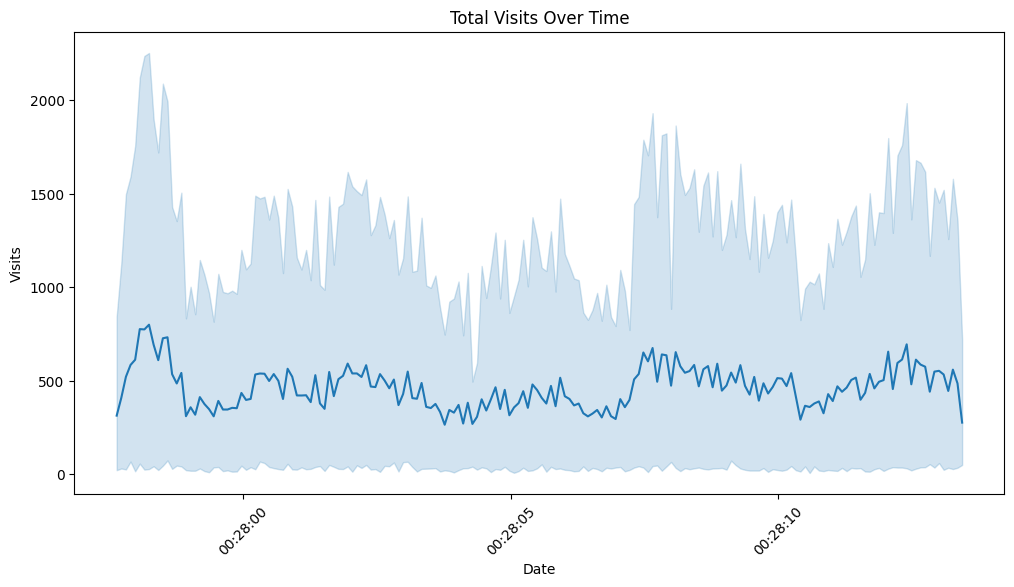

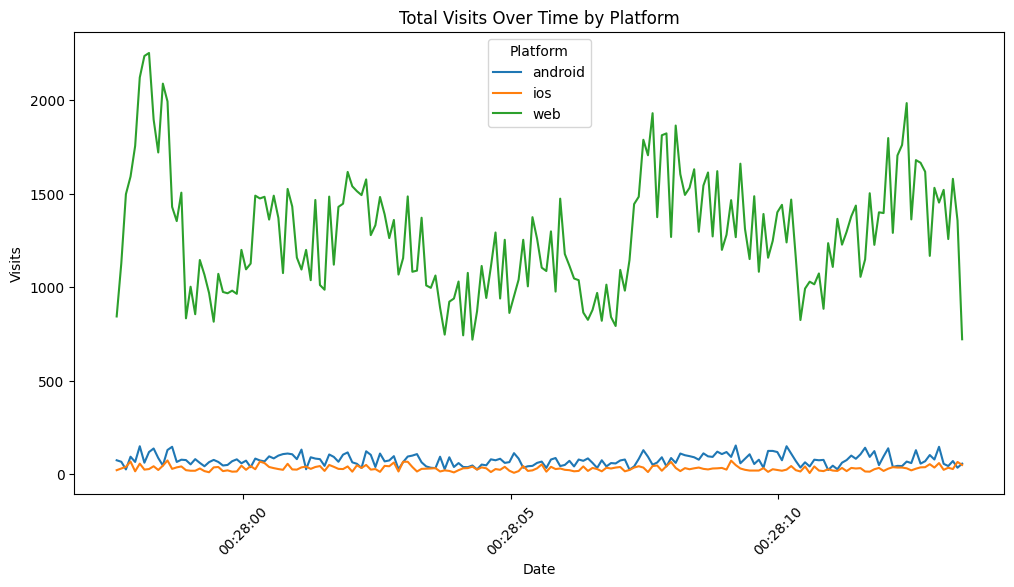

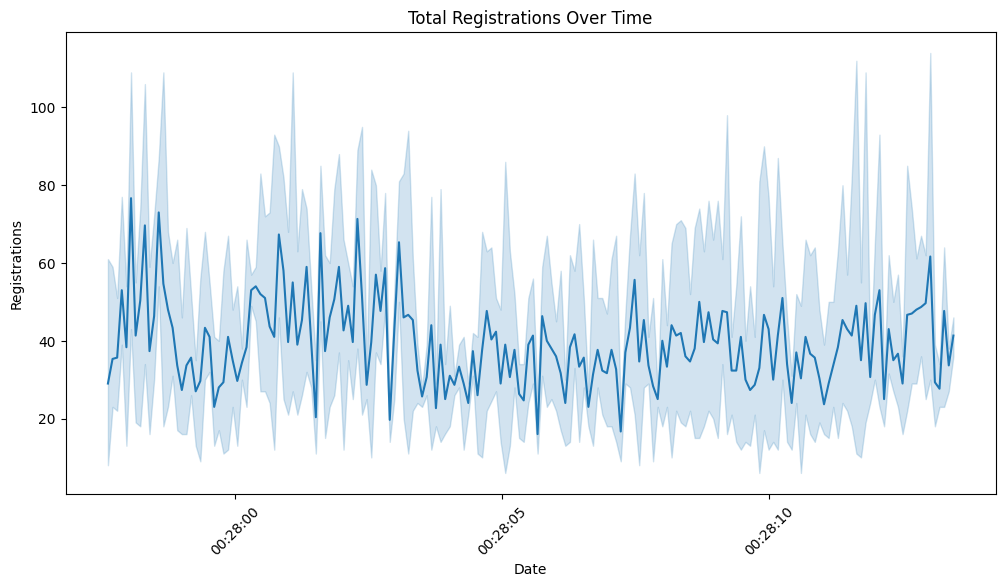

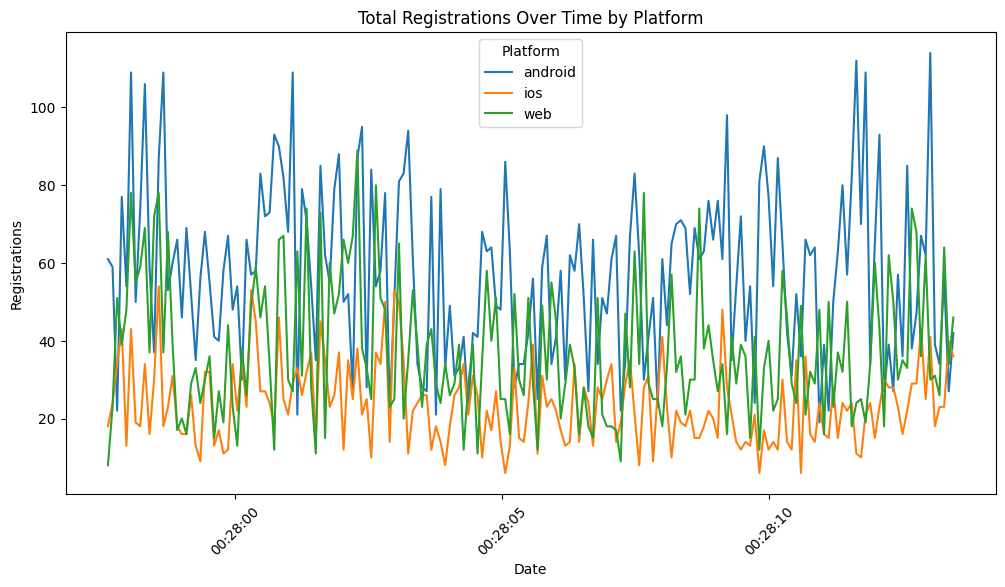

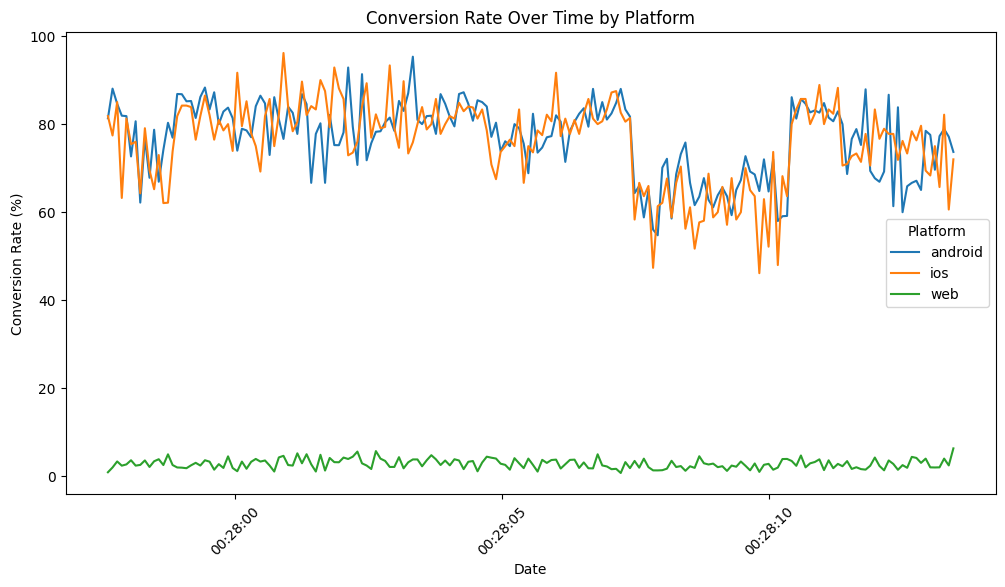

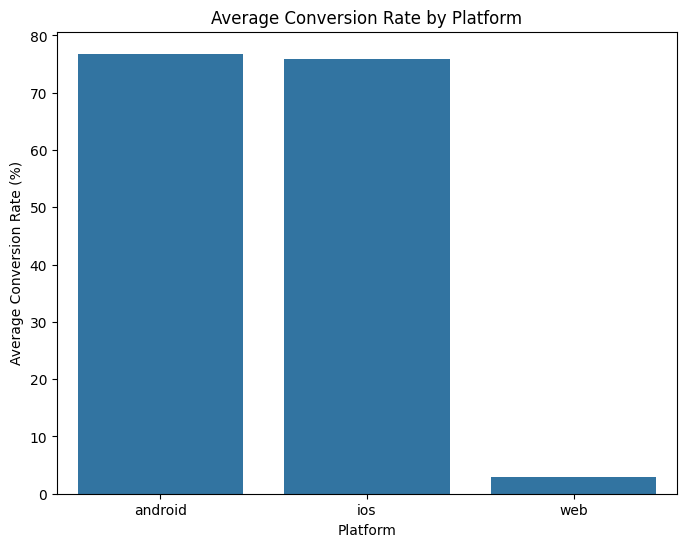

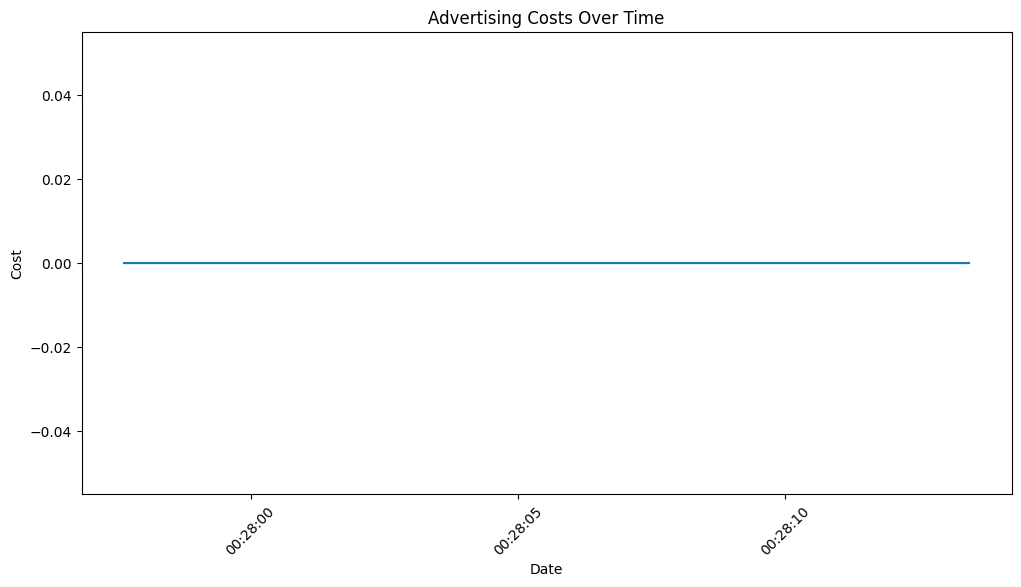

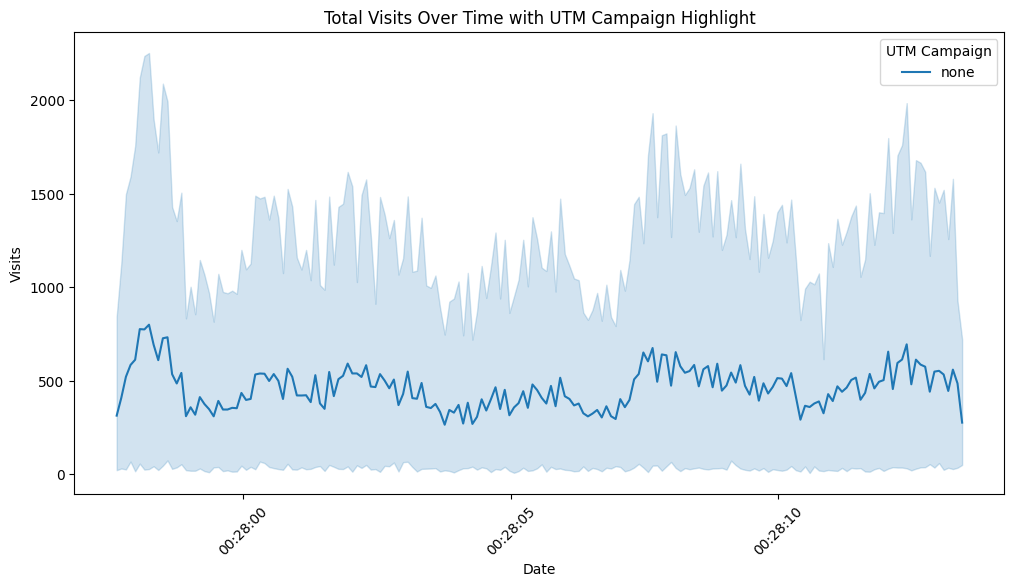

Chart saved: advertising_costs.png
Chart saved: average_conversion_rate.png
Chart saved: conversion_rate_by_platform.png
Chart saved: total_registrations.png
Chart saved: total_registrations_by_platform.png
Chart saved: total_visits.png
Chart saved: total_visits_by_platform.png
Chart saved: utm_campaign.png
JSON file created: ./conversion.json
JSON file created: ./ads.json


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from dotenv import load_dotenv
import json
import logging
os.makedirs('./check', exist_ok=True)
# logging.basicConfig(
#     filename='./check/data_processing.log',
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )

def fetch_visits(api_url, start_date, end_date):
    try:
        response = requests.get(f"{api_url}/visits?", params={'begin': start_date, 'end': end_date})
        response.raise_for_status()
        
        # Печать JSON-ответа
        visits_data = response.json()  # Получаем данные из ответа
        # file_path = 'http_visits.json'
        # with open(file_path, 'w') as f:
        #     json.dump(visits_data, f, indent=4, default=str)  # Используем indent для удобочитаемости

        # print(f"Data saved to {file_path}")
        return visits_data         # Возвращаем данные
        
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
        return None
    except Exception as err:
        print(f"Other error occurred: {err}")
        return None

def fetch_registrations(api_url, start_date, end_date):
    try:
        response = requests.get(f"{api_url}/registrations?", params={'begin': start_date, 'end': end_date})
        response.raise_for_status()
        registration_data = response.json()  # Получаем данные из ответа
        # file_path = 'http_registrations.json'
        # with open(file_path, 'w') as f:
        #     json.dump(registration_data, f, indent=4, default=str)  # Используем indent для удобочитаемости

        # print(f"Data saved to {file_path}")        # Печатаем полученные данные
        
        return registration_data
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}")
        return None
    except Exception as err:
        print(f"Other error occurred: {err}")
        return None

load_dotenv()

api_url = os.getenv("API_URL")
start_date = os.getenv("DATE_BEGIN")
end_date = os.getenv("DATE_END")

visits_data = fetch_visits(api_url, start_date, end_date)
registrations_data = fetch_registrations(api_url, start_date, end_date)

if visits_data is None or registrations_data is None:
    print("Failed to fetch data. Exiting.")
    exit(1)
# Convert data to DataFrames and prepare it
df_reg = pd.DataFrame(registrations_data)
df_vis = pd.DataFrame(visits_data)
# Filter out visits where User-Agent contains "bot"
df_vis = df_vis[~df_vis['user_agent'].str.contains("bot", case=False, na=False)]
#logging.info(f"Visits DataFrame (after filtering bots):\n{df_vis.to_string()}")

# Convert datetime columns to datetime objects
df_reg['datetime'] = pd.to_datetime(df_reg['datetime'])
df_vis['datetime'] = pd.to_datetime(df_vis['datetime'])
df_vis = df_vis.fillna(0)
df_reg = df_reg.fillna(0)
print(df_vis)

# Group visits by date and platform
df_vis_grouped = df_vis.groupby([df_vis['datetime'].dt.date, 'platform']).size().reset_index(name='visits')
#logging.info(f"Grouped Visits DataFrame:\n{df_vis_grouped.to_string()}")
print(df_vis_grouped) 
# Group registrations by date and platform
df_reg_grouped = df_reg.groupby([df_reg['datetime'].dt.date, 'platform']).size().reset_index(name='registrations')
#logging.info(f"Grouped Registrations DataFrame:\n{df_reg_grouped.to_string()}")

# Merge dataframes
merged_df = pd.merge(df_vis_grouped, df_reg_grouped, on=['datetime', 'platform'], how='left')
#merged_df['registrations'] = merged_df['registrations'].fillna(0)
#logging.info(f"Merged DataFrame:\n{merged_df.to_string()}")
print(merged_df)
merged_df['registrations'] = merged_df['registrations'].fillna(0)
# Calculate conversion
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100
#merged_df['conversion'] = merged_df['conversion'].apply(lambda x: round(x, 10))
#merged_df['conversion'] = merged_df['conversion'].fillna(0)

# Convert date to milliseconds for JSON
merged_df['date_group'] = pd.to_datetime(merged_df['datetime']).astype(int) // 10**6

# Create final JSON
final_json = {
    "date_group": {str(i): int(v) for i, v in enumerate(merged_df['date_group'])},
    "platform": {str(i): p for i, p in enumerate(merged_df['platform'])},
    "visits": {str(i): int(v) for i, v in enumerate(merged_df['visits'])},
    "registrations": {str(i): int(v) for i, v in enumerate(merged_df['registrations'])},
    "conversion": {str(i): v for i, v in enumerate(merged_df['conversion'])}
}

# Save to JSON
with open('./conversion.json', 'w') as f:
    json.dump(final_json, f, indent=4)
#logging.info("Saved final JSON to './check/conversion.json'")

# Loading ads data from CSV
ads_df = pd.read_csv('ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date
ads_agg = ads_df.groupby('date').agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()
ads_agg = ads_agg.rename(columns={'date': 'date_group'})
ads_agg['utm_campaign'] = ads_agg['utm_campaign'].fillna('none')

# Merging all data
final_df = pd.merge(merged_df, ads_agg, on='date_group', how='left')
final_df['cost'] = final_df['cost'].fillna(0)
final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
final_df.to_json('./ads.json', orient='records', date_format='iso')

# Verifying file creation
with open('./ads.json', 'r') as f:
    data = f.read()
    print(data[:1000])

# Function to prepare data
def prepare_data():
    conversion_df = pd.read_json('./conversion.json')
    ads_df = pd.read_csv('ads.csv')
    
    ads_df['date'] = pd.to_datetime(ads_df['date'])
    conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])
    
    ads_grouped = ads_df.groupby('date').agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()
    final_df = pd.merge(conversion_df, ads_grouped, left_on='date_group', right_on='date', how='left')
    
    final_df['cost'] = final_df['cost'].fillna(0)
    final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')
    
    return final_df

# Creating directory for charts
os.makedirs('./charts', exist_ok=True)

# Preparing data
final_df = prepare_data()

# Plotting charts

# Total visits over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='visits')
plt.title('Total Visits Over Time')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.savefig('./charts/total_visits.png')
plt.show()

# Total visits by platform
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='visits', hue='platform')
plt.title('Total Visits Over Time by Platform')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.savefig('./charts/total_visits_by_platform.png')
plt.show()

# Total registrations over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='registrations')
plt.title('Total Registrations Over Time')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.savefig('./charts/total_registrations.png')
plt.show()

# Total registrations by platform
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='registrations', hue='platform')
plt.title('Total Registrations Over Time by Platform')
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.savefig('./charts/total_registrations_by_platform.png')
plt.show()

# Conversion rate by platform
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='conversion', hue='platform')
plt.title('Conversion Rate Over Time by Platform')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.savefig('./charts/conversion_rate_by_platform.png')
plt.show()

# Average conversion rate by platform
average_conversion = final_df.groupby('platform')['conversion'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=average_conversion, x='platform', y='conversion')
plt.title('Average Conversion Rate by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Conversion Rate (%)')
plt.savefig('./charts/average_conversion_rate.png')
plt.show()

# Advertising costs over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='cost')
plt.title('Advertising Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.xticks(rotation=45)
plt.savefig('./charts/advertising_costs.png')
plt.show()

# Total visits with UTM campaign highlight
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='date_group', y='visits', hue='utm_campaign')
plt.title('Total Visits Over Time with UTM Campaign Highlight')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.xticks(rotation=45)
plt.legend(title='UTM Campaign')
plt.savefig('./charts/utm_campaign.png')
plt.show()

# Verifying charts
for chart in os.listdir('./charts'):
    if chart.endswith('.png'):
        print(f"Chart saved: {chart}")

# Verify JSON files creation
for file in ['./conversion.json', './ads.json']:
    if os.path.exists(file):
        print(f"JSON file created: {file}")
    else:
        print(f"JSON file not found: {file}")